In [1]:
import os
import copy
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
%matplotlib inline
from transformers import AutoTokenizer, AutoModelWithLMHead, AutoModelForSeq2SeqLM, BartForConditionalGeneration,BartTokenizer
import shap
import scipy as sp
import nlp
import torch
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option("max_rows", None)
from shap.utils import assert_import, record_import_error, safe_isinstance, make_masks, OpChain, MaskedModel
from shap import maskers, links
from transformers.file_utils import ModelOutput
#from shap.utils import cal_conditional_logits
import sys

In [2]:
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")
model = AutoModelWithLMHead.from_pretrained("Helsinki-NLP/opus-mt-en-es").cuda()

The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.


In [3]:
s="My name is <pad>, and I enjoy <pad> and <pad>!"

inputs = tokenizer([s], max_length=512, return_tensors='pt')
input_ids=inputs['input_ids'].cuda()

summary_ids = model.generate(input_ids, num_beams=1)

summary=[tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]

print(summary)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


['Mi nombre es , y me gusta y !']


In [4]:
def gen_summary(x):
    inputs = tokenizer([x], max_length=1024, return_tensors='pt',min_length=0)
    input_ids=inputs['input_ids'].cuda()
    with torch.no_grad():
        out=model.generate(input_ids)
    decoder_inputs=out[:,:-1]
    #del input_ids
    del out
    return {'decoder_inputs':decoder_inputs,'input_ids':input_ids}

In [5]:
def f_kwargs(x):
    kwargs = gen_summary(x)
    return kwargs

In [6]:
def f_cp(x_batch,**kwargs):
    output_batch=[]
    decoder_inputs=kwargs['decoder_inputs']
    for i,x in enumerate(x_batch):
        #print(f"\033[1m Masked input: \033[0m {x}")
        inputs = tokenizer([x], max_length=1024, return_tensors='pt',truncation=True)
        input_ids=inputs['input_ids']
        conditional_logits = cal_conditional_logits(input_ids,model,tokenizer,decoder_inputs)
        output_batch.append(conditional_logits)
    return np.array(output_batch)

In [7]:
def f_cp_attn(x_batch,**kwargs):
    output_batch=[]
    decoder_inputs=kwargs['decoder_inputs']
    masks = kwargs['masks']
    input_ids = kwargs['input_ids']
    for i,(x,mask) in enumerate(zip(x_batch,masks)):
        #print(f"\033[1m Masked input: \033[0m {x}")
        #inputs = tokenizer([x], max_length=1024, return_tensors='pt',truncation=True)
        #input_ids=inputs['input_ids']
        attention_mask = torch.tensor(mask).unsqueeze(0)
        conditional_logits = cal_conditional_logits(input_ids,model,tokenizer,decoder_inputs,attention_mask=attention_mask)
        output_batch.append(conditional_logits)
    return np.array(output_batch)

In [8]:
def get_encoder_outputs(input_ids,model,attention_mask):
    encoder = model.get_encoder()
    with torch.no_grad():
        encoder_outputs = encoder(input_ids, attention_mask=attention_mask, return_dict=True)
    del encoder
    return encoder_outputs

def get_conditional_logits(model, decoder_input, past, attention_mask, encoder_outputs):
    model_inputs = model.prepare_inputs_for_generation(
                    decoder_input, past=past, attention_mask=attention_mask, use_cache=True, encoder_outputs=encoder_outputs
                )
    with torch.no_grad():
        outputs = model(**model_inputs, return_dict=True)
    if "past_key_values" in outputs:
        past = outputs.past_key_values
    next_token_logits = outputs.logits[:, -1, :].detach().cpu()
    probs=next_token_logits[0].softmax(dim=0)
    del model_inputs, outputs
    #val = sp.special.logit(probs)
    return probs, past

def cal_conditional_logits(input_ids,model,tokenizer,decoder_inputs,encoder_outputs=None,attention_mask=None):
    conditional_logits=[]
    past=None
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    input_ids=input_ids.to(device)
    if attention_mask is None:
        attention_mask = (input_ids!=tokenizer.pad_token_id).type(torch.int64)
    else:
        attention_mask = attention_mask.to(device)
    '''
    summary_ids = model.generate(input_ids)
    summary=[tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    del summary_ids
    print(f"\033[1m Summary: \033[0m {summary[0]} \n")
    '''
    if encoder_outputs is None:
        encoder_outputs = get_encoder_outputs(input_ids,model,attention_mask)
    del input_ids
    for i in range(1,decoder_inputs.shape[1]):
        probs, past = get_conditional_logits(model, decoder_inputs[:,:i], past, attention_mask, encoder_outputs)
        conditional_logits.append(probs[decoder_inputs[0,i].item()])
    del past, attention_mask, encoder_outputs
    '''
    token_ids=tokenizer.convert_ids_to_tokens(decoder_inputs[0,1:].detach().cpu().numpy())
    mlp.rcParams['figure.figsize']=(10,5)
    plt.bar(token_ids,conditional_logits)
    plt.xticks(rotation=90)
    plt.show()
    '''
    return np.array(conditional_logits)

In [9]:
s="In this picture, there are four persons: my father, my mother, my brother and my sister."
explainer = shap.Explainer(f_cp,tokenizer,model_kwargs=f_kwargs)
explainer.masker.mask_token=None
explainer.masker.mask_token_str=""
explainer.masker.fixed_background = True
row_args=(s,)
fm = MaskedModel(explainer.model, explainer.model_kwargs, explainer.masker, explainer.link,*row_args)
explainer._clustering = explainer.masker.clustering(*row_args)
explainer._mask_matrix = make_masks(explainer._clustering)

explainers.Partition is still in an alpha state, so use with caution...
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Keyword arguments {'min_length': 0} not recognized.


In [31]:
feature_names = [explainer.masker.tokenizer.decode([v]) for v in explainer.masker._tokenized_s]

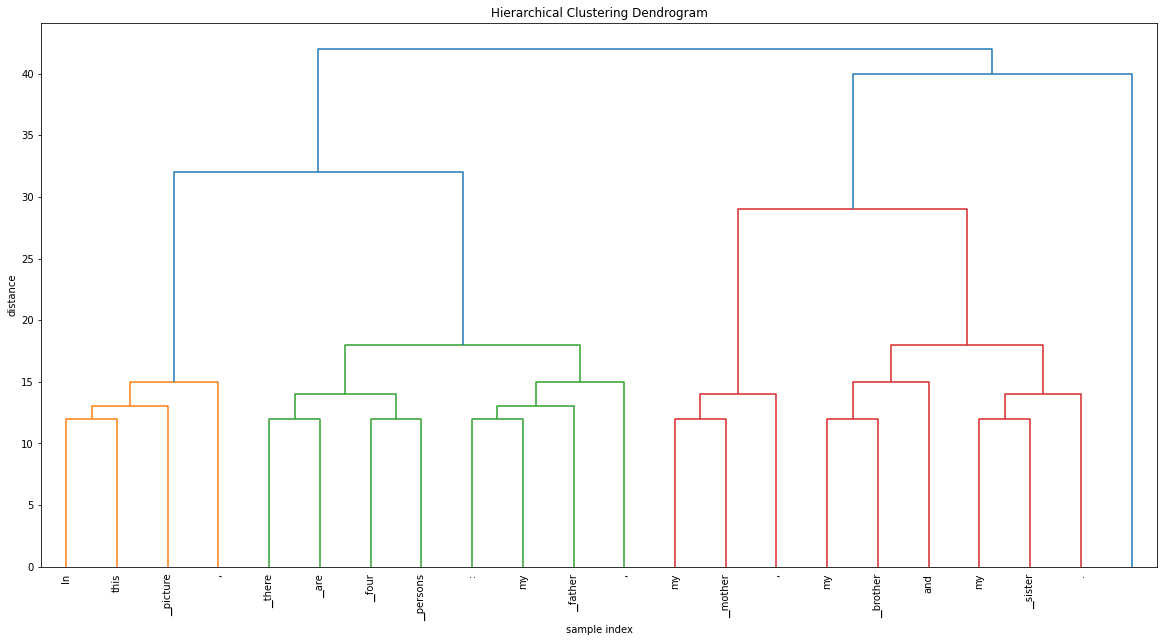

In [24]:
# plot the clustering
mlp.rcParams['figure.figsize']=(20,10)
#plt.figure(figsize=(25, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    explainer._clustering,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=feature_names,
)
plt.show()

In [32]:
def masking_experiment(clust_index,d,d_limit,feature_names,M):
    if d>d_limit:
        return
    #print(f'clust_index:{clust_index}')
    m00 = np.zeros(M, dtype=np.bool)
    m_new=m00.copy()
    mask_index=clust_index+M
    #print(f'mask_index:{mask_index}')
    m_new[:]+=explainer._mask_matrix[mask_index,:]
    batch_masks=[]
    batch_masks.append(m_new)
    batch_masks=np.array(batch_masks)
    fout = fm(batch_masks)
    #print(f'Masked string: {feature_names[m_new]}')
    lind,rind=[int(x) for x in explainer._clustering[clust_index,:2]]
    #print(f'lind:{lind} rind:{rind}')
    masking_experiment(lind-M if lind>=M else lind,d+1,d_limit,feature_names,M)
    masking_experiment(rind-M if rind>=M else rind,d+1,d_limit,feature_names,M)

In [33]:
def reference_evaluation(M):
    m00 = np.zeros(M, dtype=np.bool)
    batch_masks=[]
    batch_masks.append(m00)
    batch_masks=np.array(batch_masks)
    fout = fm(batch_masks)

 Masked input:  
 Summary:  - No, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no. 



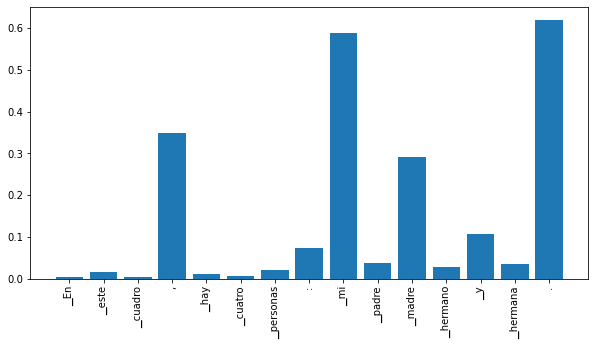

 Masked input:  In this▁picture,▁there▁are▁four▁persons: my▁father, my▁mother, my▁brother and my▁sister.
 Summary:  En este cuadro, hay cuatro personas: mi padre, mi madre, mi hermano y mi hermana. 



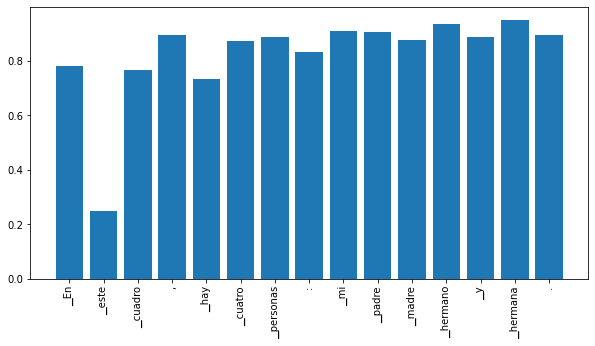

 Masked input:  In this▁picture,▁there▁are▁four▁persons: my▁father,
 Summary:  En esta foto, hay cuatro personas: mi padre, 



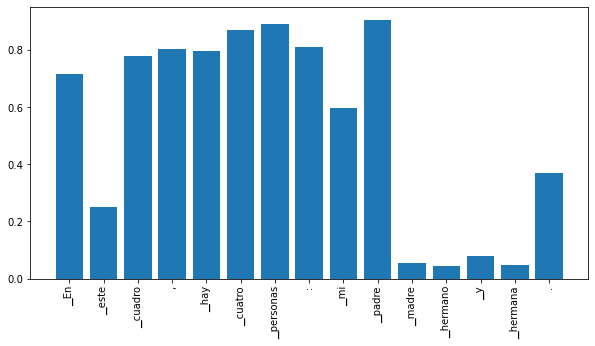

 Masked input:  my▁mother, my▁brother and my▁sister.
 Summary:  mi madre, mi hermano y mi hermana. 



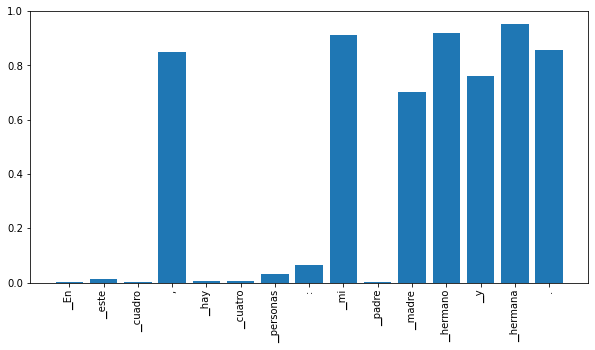

In [34]:
d=0
d_limit=1
M = len(fm)
clust_index=M-2
reference_evaluation(M)
masking_experiment(clust_index,d,d_limit,np.array(feature_names),M)

In [10]:
explainer = shap.Explainer(f_cp,tokenizer,model_kwargs=f_kwargs)
explainer.masker.mask_token=None
explainer.masker.mask_token_str=""
explainer.masker.fixed_background = True

In [11]:
shap_values = explainer([row_args[0]])

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Keyword arguments {'min_length': 0} not recognized.


Index in batch: 42
Interaction effect for index 42: [-6.48328123e-02 -1.02104712e-03  8.36223073e-03  7.13843554e-02
  5.69300833e-02 -7.36709917e-03  1.47164706e-02 -3.30140963e-02
  2.70242759e-01 -3.50295978e-02  4.47637290e-01 -2.88848551e-01
 -4.13737006e-01  7.24337101e-02 -4.96370830e-01 -3.58041376e-04
 -1.54598773e-01 -3.29654515e-02  1.28218234e-02 -2.88170844e-01]
Index in batch: 42
Interaction effect for index 41: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Interaction effect for index 40: [-0.02240379 -0.13358012 -0.14560813  0.21907078 -0.43448384 -0.05700223
 -0.11552075  0.09909046  0.11752081 -0.00062083  0.01564783 -0.02363223
 -0.21138102 -0.03329253 -0.00901175 -0.03322428 -0.0493924  -0.00489998
 -0.00082874 -0.07625109]
Index in batch: 40
Interaction effect for index 39: [-0.00228345  0.00500907 -0.0029183  -0.02332881 -0.00301653 -0.00199115
 -0.00446469 -0.01186436  0.1942181  -0.00394803  0.0732047   0.90127137
 -0.06569361 -0.39657182 -0.0685

Interaction effect for index 27: [ 0.00128597 -0.00137953  0.00285679 -0.00094679 -0.002873   -0.00516737
  0.00229907  0.00323766 -0.00896108 -0.00184536 -0.00087857  0.0049966
  0.00951886  0.64102903  0.59916486  0.00481285  0.77355053  0.12628558
  0.56264672  0.00230014]
Interaction effect for index 28: [-1.31726265e-03 -2.73816288e-03 -5.12194633e-03 -1.75708532e-03
 -6.28662109e-03  9.71555710e-05 -1.16187334e-03  6.70552254e-04
 -3.33166122e-03  4.99129295e-04 -1.98817253e-03  8.34465027e-04
  3.57753038e-03 -3.88586521e-03 -2.07231045e-02 -2.51418352e-03
  8.20595026e-02  1.13236276e-01 -4.61858027e-02  3.28422189e-02]
Interaction effect for index 26: [ 5.04606962e-03  1.66052580e-03  1.67161226e-03  1.01943612e-02
  1.27601624e-03  4.45902348e-04  3.11118364e-03 -2.33465433e-03
  1.80262327e-03  1.30295753e-03  3.00168991e-04 -2.36743450e-01
  1.50599244e-02  3.20035398e-01  1.39331818e-02  3.04692984e-02
  2.96660066e-02  6.54715300e-03  3.59863043e-03  2.28577852e-03]
Index

In [12]:
def summarize(x,model,tokenizer):
    print(f"Masked input: {x}")
    inputs = tokenizer([x], max_length=512, return_tensors='pt')
    input_ids=inputs['input_ids'].cuda()
    summary_ids = model.generate(input_ids).detach().cpu().numpy()
    del input_ids
    summary=[tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    print(f"summary: {summary[0]}")
    return summary_ids[0,1:-1]

In [13]:
ids=summarize(row_args[0],model,tokenizer)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Masked input: In this picture, there are four persons: my father, my mother, my brother and my sister.
summary: En este cuadro, hay cuatro personas: mi padre, mi madre, mi hermano y mi hermana.


In [14]:
for i,id in enumerate(ids):
    print(f'Output token: {tokenizer.convert_ids_to_tokens(int(id))}')
    shap.plots.text(shap_values[0][:,i],group_threshold=1)

Output token: ▁En


Output token: ▁este


Output token: ▁cuadro


Output token: ,


Output token: ▁hay


Output token: ▁cuatro


Output token: ▁personas


Output token: :


Output token: ▁mi


Output token: ▁padre


Output token: ,


Output token: ▁mi


Output token: ▁madre


Output token: ,


Output token: ▁mi


Output token: ▁hermano


Output token: ▁y


Output token: ▁mi


Output token: ▁hermana


Output token: .


In [44]:
explainer_attn = shap.Explainer(f_cp_attn,tokenizer,model_kwargs=f_kwargs)
explainer_attn.masker.mask_token=None
explainer_attn.masker.mask_token_str=""
explainer_attn.masker.fixed_background = True

explainers.Partition is still in an alpha state, so use with caution...


In [45]:
shap_values_attn = explainer([row_args[0]])

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Keyword arguments {'min_length': 0} not recognized.


In [46]:
for i,id in enumerate(ids):
    print(f'Output token: {tokenizer.convert_ids_to_tokens(int(id))}')
    shap.plots.text(shap_values_attn[0][:,i],group_threshold=1)

Output token: ▁En


Output token: ▁este


Output token: ▁cuadro


Output token: ,


Output token: ▁hay


Output token: ▁cuatro


Output token: ▁personas


Output token: :


Output token: ▁mi


Output token: ▁padre


Output token: ,


Output token: ▁mi


Output token: ▁madre


Output token: ,


Output token: ▁mi


Output token: ▁hermano


Output token: ▁y


Output token: ▁mi


Output token: ▁hermana


Output token: .
